### Imports

In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

### Load data
Run the first cell if samples are stored individually  
Run the second cell if samples are stored in the same matrix (requires meta data file)

In [ ]:
# Load samples from distinct matrix files
mysamples = {
    'CTRL' : '../data/samples/PBMC.mtx',
    'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
    'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
    'IL2_10ng/ml' : '../data/samples/IL2.mtx',
    'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
}
mygenes = '../data/samples/genes.tsv'

pop = PA.load_samples(samples=mysamples, 
                      genes=mygenes,
                      outputfolder='output_samples')

In [3]:
# Load samples from one matrix file with metadata
# (must include cell_barcode, sample_id columns)
"""
mymatrix = '../data/screen/PBMC-MULT-8/matrix.mtx'
mybarcodes = '../data/screen/PBMC-MULT-8/barcodes.tsv'
mygenes = '../data/screen/PBMC-MULT-8/features.csv'
mymetadata = '../data/screen/PBMC-MULT-8/updated_meta.csv'
"""
mymatrix = '../data/screen/PBMC-MULT-6/PBMC-MULT-6.mtx'
mybarcodes = '../data/screen/PBMC-MULT-6/barcodes.tsv'
mygenes = '../data/screen/PBMC-MULT-6/genes.tsv'
mymetadata = '../data/screen/PBMC-MULT-6/updated_meta.csv'

pop = PA.load_multiplexed(matrix=mymatrix, 
                     barcodes=mybarcodes, 
                     metafile=mymetadata, 
                     genes=mygenes,
                     outputfolder='output_multiplexed_pbmc6_nocd3',
                     only=[], # list of sample names to only load the specified samples
                     col='CD3', # either None or a column name from the meta data
                     value=0) # if col != None, specify value in column to filter samples

In [4]:
PA.print_ncells(pop)

CONTROL 	 8058
Mianserin HCl 	 1116
Pomalidomide 	 1309
Loteprednol etabonate 	 750
Celecoxib 	 819
Sulfasalazine 	 1161
Methotrexate 	 646
Busulfan 	 1254
Rapamycin 	 734
Tranilast 	 1082
Budesonide 	 1178
Everolimus 	 1015
Acetylcysteine 	 996
Zafirlukast 	 1193
Bimatoprost 	 1029
Adapalene 	 896
Triamcinolone Acetonide 	 921
Thalidomide 	 977
Isotretinoin 	 1057
Ketoprofen 	 1110
Doramapimod 	 915
Cetirizine DiHCl 	 779
Betamethasone Valerate 	 1108
Phenylbutazone 	 994
Naproxen Sodium 	 572
Flurbiprofen 	 1007
Meprednisone 	 1088
Latrepirdine 2HCl 	 1016
Mesalamine 	 1048
Nepafenac 	 1052
Zileuton 	 1125
Cyclosporine 	 572
Tazarotene 	 1180
Allopurinol Sodium 	 880
Etodolac 	 863
Alprostadil 	 788
Dexrazoxane HCI 	 971
Ibuprofen 	 1139
Loratadine 	 327
Ifosfamide 	 980
Mercaptopurine 	 1008
Febuxostat 	 1163
Masitinib 	 678
Total number of cells loaded: 48554


### Normalize and gene filter

In [5]:
# Perform column normalization
# Find best normalization factor
'''
Parameters
----------
scaling factor: Number used to scale the data values. If None, that factor is computed automatically.
ncells: Number of cells to randomly subsample to try different normalization factors to use less memory. If None, all cells are used.
'''
PA.normalize(pop, scaling_factor=None, ncells=None)

Performing column normalization
Finding best scaling factor


1541 genes selected


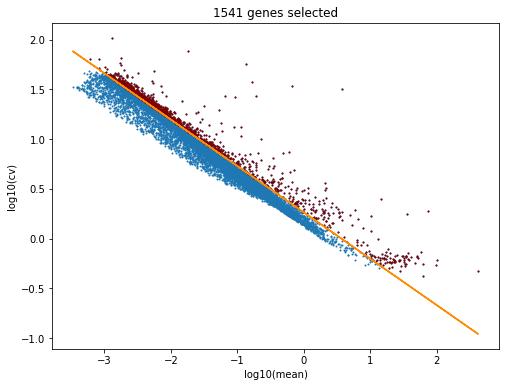

In [9]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
'''
Parameters
----------
offset: Value (its log) will be added to the intercept of the linear fit to filter genes
'''
PA.plot_gene_filter(pop, offset=1.17)

In [10]:
# Gene filter the data with the last offset value used in the previous step
'''
Parameters
----------
remove_ribosomal: remove genes that start with RPS or RPL if True
'''
PA.filter(pop, remove_ribsomal=True)

Removing ribosomal genes
Filtering genes ang logging data


In [ ]:
# Remove red blood cells from the data
PA.removeRBC(pop, species='human')

### Dimensionality reduction

In [11]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
'''
Parameters
----------
ncells: Number of cells to randomly sample
nfeats: Number or list of numbers of features to use
nreps: Number of repetitions to perform for each k in nfeats
niter: Maximum number of iterations to perform for each instance of the algoirthm
'''
importlib.reload(PA)
PA.onmf(pop, ncells=5000, nfeats=[7,9], nreps=3, niter=500)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #499
......... Iteration #499
Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

......... Iteration #499
Orthogonal NMF performed with 500 iterations

......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #499
...

### Grid of samples in embedding space

In [ ]:
importlib.reload(PA)
PA.embedding_grid(pop, method='tsne', figsize=(20,20))

In [ ]:
PA.embedding_grid(pop, method='umap', figsize=(20,20))

### Build probabilistic models

In [12]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
'''
Parameters
----------
ks: Number or range (tuple) of components to use
niters: number of replicates to build for each k in `ks`
training: If training is float, the value will be used a percentage to select cells for the training set. Must follow 0<value<1
          If training is int, that number of cells will be used for the training set.
nreplicates: Number of model replicates to generate for each sample. These replicates model will be used to provide confidence intervals later in the analysis.
rendering: One of grouped, individual or unique
types: Dictionary of cell type markers, 'defaultpbmc' or None
figsizegrouped: Size of the figure for the renderings together. Default is (20,20)
figsizesingle: Size of the figure for each single sample rendering. Default is (5,5)
'''
importlib.reload(PA)
PA.build_gmms(pop, 
              ks=(8,10), 
              niters=2,
              training=.8, 
              nreplicates=1,
              reg_covar='auto', 
              rendering='grouped', 
              types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
              figsizegrouped=(20,20),
              figsizesingle=(6,5))

Building model for CONTROL (1 of 43)
Building model for Mianserin HCl (2 of 43)
Building model for Pomalidomide (3 of 43)
Building model for Loteprednol etabonate (4 of 43)
Building model for Celecoxib (5 of 43)
Building model for Sulfasalazine (6 of 43)
Building model for Methotrexate (7 of 43)
Building model for Busulfan (8 of 43)
Building model for Rapamycin (9 of 43)
Building model for Tranilast (10 of 43)
Building model for Budesonide (11 of 43)
Building model for Everolimus (12 of 43)
Building model for Acetylcysteine (13 of 43)
Building model for Zafirlukast (14 of 43)
Building model for Bimatoprost (15 of 43)
Building model for Adapalene (16 of 43)
Building model for Triamcinolone Acetonide (17 of 43)
Building model for Thalidomide (18 of 43)
Building model for Isotretinoin (19 of 43)
Building model for Ketoprofen (20 of 43)
Building model for Doramapimod (21 of 43)
Building model for Cetirizine DiHCl (22 of 43)
Building model for Betamethasone Valerate (23 of 43)
Building mode

In [ ]:
# If the renderings do not have the right figure size, regenerate the renderings with:
#PA.render_models(pop, figsizegrouped=(20,20), figsizesingle=(6,5), mode='grouped')

### Align subpopulations

In [98]:
# Use a reference sample's gmm to assign cells from test samples
# to its various components, and compute varition metrics between
# a reference component attributes and test sample cells matching it
'''
Parameters
----------
ref: Name of reference sample
figsize: Size of the output figure
pointsize: Size of the points in the figure
'''
PA.assign_align(pop, ref='CONTROL', figsize=(15,15), pointsize=10)

In [ ]:
# Align subpopulations of each sample against a reference model's subpopulations
'''
Parameters
----------
ref: Name of reference sample
method: Method to perform the alignment
    If 'conservative', the reference component and the test component have to be each other's best match to align
    If 'test2ref', the closest reference component is found for each test component
    If 'ref2test', the closest test component is found for each test component
figsizedeltas: Size of the figure for the delta plot. Default is (10,5)
figsizeentropy: Size of the figure for the entropy plot. Default is (10,5)
'''
importlib.reload(PA)
PA.align(pop, ref='CONTROL',
         method='test2ref', # one of: test2ref, ref2test, conservative
         figsizedeltas=(10,10),
         figsizeentropy=(10,10))

In [ ]:
# Get list of differentially expressed genes between a reference subpopulation
# and a sample's subpopulation that aligned to it
'''
Parameters
----------
refcomp : Component number of one of the reference subpopulations
sample : Sample name
'''
importlib.reload(PA)

refcomp = 1
sample = 'Loteprednol etabonate'
genelist = PA.diffexp(pop,
                      refcomp=refcomp,
                      sample=sample,
                      nbins=20,
                      cutoff=1,
                      renderhists=True,
                      usefiltered=True)

In [ ]:
importlib.reload(PA)
PA.plot_heatmap(pop,
                refcomp=refcomp,
                genelist=genelist,
                clustersamples=True,
                clustercells=False,
                savename='%d_%s' % (refcomp,sample) ,# either None or a string
                figsize=(20,20),
                cmap='Purples',
                samplelimits=False,
                scalegenes=True,
                only=None,
                equalncells=False)

### Visualize genes in subpopulations

In [ ]:
importlib.reload(PA)
PA.plot_genes_gmm_cells(pop,
               sample='unique',
               genelist=genelist,
               savename='',
               metric='correlation',
               method='single',
               clustergenes=False,
               clustercells=False,
               cmap='magma',
               figsize=(15,15)
)

### Rank samples

In [ ]:
# Rank each sample against a reference sample's model
importlib.reload(PA)
PA.rank(pop,
        ref='CTRL', # label of the reference sample
        k=100, # number of cells to randomly sample from sample
        niter=200, # number of iterations
        method='LLR', # LLR for log-likelihood ratio or LL for log-likelihood
        mincells=50, # sample's minimum number of cells to be ranked
        figsize=(10,5)) # plot figure size

### Build unique GMM for all samples

In [ ]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, 
                    ks=(5,20), 
                    niters=3, 
                    training=0.2, 
                    reg_covar=True, 
                    types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
                    figsize=(6,5))

In [ ]:
# Generate a query plot
PA.plot_query(pop,  pcells=.2, nreps=10, figsize=(5,20), sharey=True)

### 2D visualization

In [ ]:
# Highlight markers in an embedded space
PA.scatter(pop, method='umap', color='CD3D')
PA.scatter(pop, method='umap', color='LYZ')
scatter(pop, method='umap', sample='CONTROL', compnumber=0, color='CD3D')
PA.scatter(pop, method='tsne', color='CD3D')
PA.scatter(pop, method='tsne', color='LYZ')
scatter(pop, method='tsne', sample='CONTROL', compnumber=0, color='CD3D')

In [ ]:
# Highlight samples in an embedded space
PA.samples_grid(pop, method='tsne', figsize=(20,20))

In [ ]:
# Highlight sample subpopulations in an embedded space
PA.subpopulations_grid(pop, method='tsne', figsize=(20,20))

### 3D visualization

In [ ]:
# Interactive 3D visualization of the data in feature space
importlib.reload(PA)
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

### Work in progress

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#-------------- WORK IN PROGRESS BELOW ----------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
from multiprocessing import Pool
import numpy as np
import os

def diffexp_two_matrices(M1, M2, genes, nbins=20, cutoff=.7):
    M1 = M1.toarray()
    M2 = M2.toarray()
    
    with Pool(pop['ncores']) as p:
        q = np.array(p.starmap(PA.l1norm, [(ig, M1[ig,:], M2[ig,:], nbins) for ig in range(M1.shape[0])])) # for each gene idx ig, call the l1norm function
    
    idx = np.argsort(q)
    q = q[idx]
    genes = np.array(genes)
    genes = genes[idx]
    
    downregulated_idx = np.where(np.array(q)<-cutoff)[0] # get indices of genes with low l1-norm values
    upregulated_idx = np.where(np.array(q)>cutoff)[0] # get indices of genes with high l1-norm values
    downregulated = [genes[i] for i in downregulated_idx] # get gene labels
    upregulated = [genes[i] for i in upregulated_idx] # get gene labels
    
    # render l1norm values
    x = np.arange(len(q))
    y = q
    plt.scatter(x, y, s=.1, alpha=1)
    plt.axhline(y=cutoff, color='red', linewidth=.5, label='Cutoff')
    plt.axhline(y=-cutoff, color='red', linewidth=.5)
    plt.xticks([])	
    plt.ylabel('l1-norm')
    plt.xlabel('Genes')
    plt.legend()
    
    return downregulated, upregulated

# Differential expression between two sparse matrices
downregulated, upregulated = diffexp_two_matrices(M1, M2, genes, cutoff=.9) 

In [ ]:
#def subpopulations_grid(pop, method='tsne', figsize=(20,20), size_background=.1, size_subpops=1):
'''
Generate grid plots of sample subpopulations in an embedding space

pop : dict
    Popalign object
method : str
    Embedding method. One of tsne, umap
figsize : tuple
    Size of the figures to be generated
size_background : float, int
    Point size for the embedding scatter in the background
size_subpops : float, int
    Point size for the highlighted subpopulations
'''

method='tsne'
figsize=(20,20)
size_background=.1
size_subpops=1

if method not in pop: # if method not run before
    X = cat_data(pop, 'C') # retrieve feature space data
    if method == 'umap': # if method is umap
        X = umap.UMAP().fit_transform(X) # run umap
    elif method == 'tsne': # if method is tsne
        X = TSNE(n_components=2).fit_transform(X) # run tsne
    else: # if method not valid
        raise Exception('Method value not supported. Must be one of tsne, umap.') # raise exception
    pop[method] = X # store embedded coordinates
else: # if method has been run before
    X = pop[method] # retrieve embedded coordinates

x = X[:,0] # get x coordinates
y = X[:,1] # get y coordinates


C = PA.cat_data(pop, 'C') # get sample feature data
gmm = pop['gmm'] # get sample gmm
poplabels = pop['gmm_types'] # get subpopulations labels
prediction = gmm.predict(C) # get subpopulation assignments for the cells

n = C.shape[0] # get number of cells
nr, nc = nr_nc(gmm.n_components) # get number of rows and columns for the grid plot
fig, axes = plt.subplots(nr,nc,figsize=figsize) # create figure and subaxes
axes = axes.flatten()

for i in range(gmm.n_components): # for each subpopulation of sample
    ax = axes[i] # assign sub axis
    idx = np.where(prediction==i)[0] # get cell indices for that subpopulations
    xtmp = x[idx] # subset cells
    ytmp = y[idx] # subset cells
    ax.scatter(x, y, c='lightgrey', s=size_background) # plot all cells as background
    ax.scatter(xtmp, ytmp, c='purple', s=size_subpops) # plot subpopulation cells on top
    ax.set(xticks=[]) # remove x ticks
    ax.set(yticks=[]) # remove y ticks
    ax.set(title='Subpopulation #%d\n%s' % (i, poplabels[i])) # set title
    if i % nc == 0:
        ax.set(ylabel='%s2' % method) # set y label
    if i >= len(pop['order'])-nc:
        ax.set(xlabel='%s1' % method) # set x label

rr = len(axes)-gmm.n_components # count how many empty plots in grid
for i in range(1,rr+1):
    ax = axes[-i] # backtrack extra sub axes
    ax.axis('off') # clear empty axis from plot

dname = 'embedding/subpopulations/' # folder name
mkdir(os.path.join(pop['output'], dname)) # create folder if does not exist
plt.savefig(os.path.join(pop['output'], dname, '%s_subpopulations.png' % sample), dpi=200) # save plot
plt.close() # close plot
start = end # update start index